### The Linear Regression File 

#### questions to answer:
##### do we need to use svm to 

In [156]:
### QUESTIONS FOR THE TA'S ###
# "It matches the training set too closely"
# - is my approach for determining if the testing data is to close to the model good (area between test LOBF and model LOBF)

# 1) get the orange lines on the purple LOBF (done (you were not accounting for the mult lin reg eq and therefore neglecting that you needed to predict on the other features))
# 2) make some graphs for the MAE MSE RMSE 
# 3) get a LOBF for the test set (not necisarry)
# 4) determine what to do about the other features (what about the most influential one) (ask carson about this)
# 5) we have the prediction graphs and 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [157]:
# test_list = ['first', 'second', 'third']
# final_dict = {}
# for i, element in enumerate(test_list):
# 	g = {'x' : i*i, 'y' : i+1}
# 	final_dict[element] = g
# print(final_dict)
# print(final_dict['second']['y'])
##############################################################################################################
arr = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
X = np.array([arr + (arr[-1]*i) for i in range(len(arr) - 2)])

def generate_y(array, horizon):
    close = array[:,4] ### 1)
    return close[horizon:] ### 2)


horizon = 7
G = X[:-horizon]
y = generate_y(X,horizon)

X_shape = X.shape
y_shape = y.shape

print(G.shape)
print(y_shape)


# # print(X)
# print(f'X.shape : {X.shape}')

# print('--'*25)

# horizon = 7
# G = X[:, :-horizon]
# # G = X
# J = G[:,4]

# print('--'*25)
# print(G)
# print(G.shape)
# print('--'*25)
# print(J)
# print(J.shape)
# print('--'*25)

# print('--'*25)

##############################################################################################################
# number of days since start | open | high | low | close | sma(10 days) | golden cross | death cross
#          0                 |  1   |  2   |  3  |   4   |      5       |      6       |      7

(3, 12)
(3,)


In [158]:
import preprocess
files = preprocess.potential_files[:5]

preprocess_class_instantiation = preprocess.preprocess(files, 7)

datasets = preprocess_class_instantiation.generate_data()

file_for_given_row = {}
for index, crypto_name in enumerate(files):
    file_for_given_row[crypto_name] = index
    # if crypto_name == '1INCH.csv':
    # print(f'index : {index} -- crypto_name : {crypto_name}')

# for key, val in file_for_given_row.items():
#     print(key, val)
    

# print(file_for_given_row['1INCH.csv'])

for f in files:
    print(f"https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select={f}")



# print(datasets)

processing files
Loading 1INCH.csv...
Loading AAVE.csv...
Loading ADA.csv...
Loading ALGO.csv...
Loading AMP.csv...
The columns are: (number of days since start,open,high,low,close,sma(10 days),golden cross, death cross)
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=1INCH.csv
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=AAVE.csv
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=ADA.csv
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=ALGO.csv
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=AMP.csv


In [159]:

for row, X_array in enumerate(datasets):
#     # 0 is X
#     # 1 is y
#     print(f'{X_array}')
    print(f'{datasets[row][0]} -- {X_array}')
# #     print(f'{datasets[row][0]} --')
# #     print('--'*50)

# for i in datasets:
    # print(i)
    

[[0 2.305 2.345 ... 2.2802857142857142 0 0]
 [1 2.224 2.41 ... 2.302571428571428 0 0]
 [2 2.343 2.436 ... 2.327285714285714 0 0]
 ...
 [1527 0.190662 0.193461 ... 0.18393299999999999 0 0]
 [1528 0.190247 0.2113 ... 0.18784714285714285 0 0]
 [1529 0.202741 0.2063 ... 0.1928485714285714 0 0]] -- (array([[0, 2.305, 2.345, ..., 2.2802857142857142, 0, 0],
       [1, 2.224, 2.41, ..., 2.302571428571428, 0, 0],
       [2, 2.343, 2.436, ..., 2.327285714285714, 0, 0],
       ...,
       [1527, 0.190662, 0.193461, ..., 0.18393299999999999, 0, 0],
       [1528, 0.190247, 0.2113, ..., 0.18784714285714285, 0, 0],
       [1529, 0.202741, 0.2063, ..., 0.1928485714285714, 0, 0]],
      dtype=object), array([2.792, 2.936, 2.809, ..., 0.199069, 0.189293, 0.182086],
      dtype=object))
[[0 448.49 485.36 ... 474.1985714285714 0 0]
 [1 481.02 482.68 ... 476.2614285714285 0 0]
 [2 453.37 469.78 ... 476.39571428571423 0 0]
 ...
 [1617 180.006 188.81 ... 171.26104285714285 0 0]
 [1618 186.0386 187.9988 ... 1

In [160]:
##### NESTED LIST RETRIEVAL OF X FOR GIVEN CURRENCY ##################################################################################
# filename = '1INCH.csv'

def get_X_or_y_for_given_currency(currency, x_or_y):
    processed_file_dict = {}

    if (x_or_y == 'X') or (x_or_y == 'x'):
        x_or_y = 0
    elif (x_or_y == 'Y') or (x_or_y == 'y'):
        x_or_y = 1
    else:
        print(f'x_or_y needs to be x or y')
    
    row = file_for_given_row[currency]
    
    for csv_name, row in file_for_given_row.items():
        if currency == csv_name:
            processed_file_dict[csv_name] = datasets[row][x_or_y]
            return processed_file_dict[csv_name]
    
# get_X_or_y_for_given_currency(filename, 'X')
# get_X_or_y_for_given_currency(filename, 'y')

In [161]:
currency_we_want_to_look_at = 'AAVE.csv'

X = get_X_or_y_for_given_currency(currency_we_want_to_look_at, 'X')
y = get_X_or_y_for_given_currency(currency_we_want_to_look_at, 'y')

print(X.shape)
print(y.shape)

# print("first row of X:", X[0])
# print("first 10 closes from X[:,4]:", X[:10, 4])
# print("first 10 y values:", y[:10])


(1620, 8)
(1620,)


# underfitted example of the first feature for a given dataset 

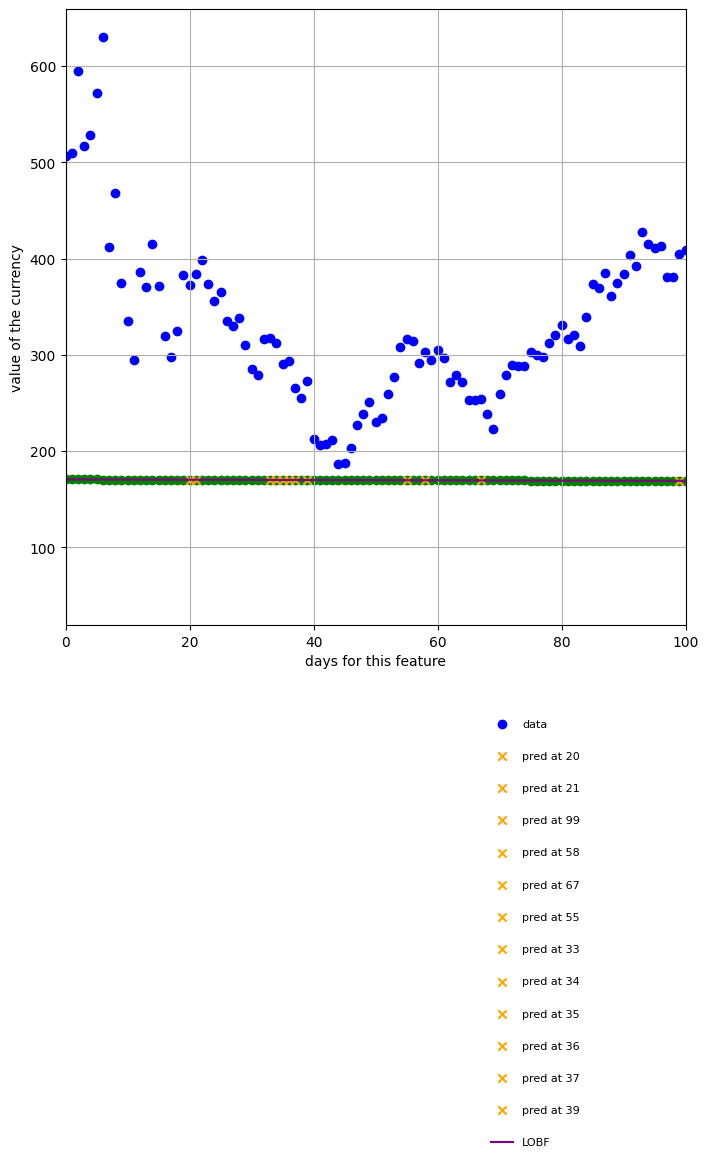

In [178]:

X0 = X[:, [0]] ## number of days since start
# X0 = X
pred_x_at_this_point = [20, 21, 99, 58, 67, 55, 33, 34, 35, 36, 37, 39]
### NOTE instantiate, fit, predict on X							#### MEMORIZE
lin_reg_model = LinearRegression()

lin_reg_model.fit(X0, y)
y_pred = lin_reg_model.predict(X0)


fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(111)

ax.scatter(X0, y, color='blue', alpha=1, label='data')

ax.scatter(X0,y_pred, color='green')

for i in pred_x_at_this_point:
	y_pred_new_x = lin_reg_model.predict(np.array([[i]]))#### MEMORIZE
	ax.scatter(i, y_pred_new_x, color='orange', marker='x', label=f'pred at {i}')

# for x_value, y_value in zip(X0[:, 0], y_pred):
#     # print(f'(x_value, y_value) : ({x_value}, {y_value})')
#     ax.annotate(f'({x_value}, {y_value})', (x_value,y_value), textcoords='offset fontsize', xytext=(2,1), fontsize=8, color='green')
    
# for x_value, y_value in zip(X0[:, 0], y):
#     # print(f'(x_value, y_value) : ({x_value}, {y_value})')
#     ax.annotate(f'({x_value}, {y_value})', (x_value,y_value), textcoords='offset fontsize', xytext=(1,1), fontsize=8, color='blue')
ax.set_xlim(0,100)
ax.plot(X0, y_pred, color='purple', label='LOBF')

# for i in range(len(X0)):
#     ax.arrow(X0[i, 0],y_pred[i],0,y[i]-y_pred[i], length_includes_head=True, color='red')

ax.set_xlabel('days for this feature')
ax.set_ylabel('value of the currency')
ax.legend(loc='center left', bbox_to_anchor=(0.5, -0.5), ncol=1, fontsize=8, frameon=False, borderaxespad=10, labelspacing=2)
ax.grid()
#################################################################################################################################

# Multivariable Linear Regression Section
### 1) find the most sig weihts (features) and dicuss what that means
### 2) get the LOBF to be fitted to the data trajectory
### 3) discuss various errors measured against the data and what that tells us about the real values vs our pred values ()

### find the magnitue and sign of coefficients

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### NOTE: instantiate Ridge class
lin_reg_model = Ridge()

### NOTE: fit the model (the obj) to the train of the lables and the dataset
lin_reg_model_train = lin_reg_model.fit(X_train, y_train)
### NOTE: make prediction lables for the train set
y_pred_train = lin_reg_model.predict(X_train)###########################################
### NOTE: make prediction lables for the test set
y_pred_test = lin_reg_model.predict(X_test)###########################################

### NOTE: get the MAE that measures the training lables against the predicted training labels
train_MAE = mean_absolute_error(y_train, y_pred_train)
### NOTE: get the MAE that measures the test lables against the predicted test labels
test_MAE = mean_absolute_error(y_test, y_pred_test)

train_MSE = mean_squared_error(y_train, y_pred_train)
test_MSE = mean_squared_error(y_test, y_pred_test)

train_RMSE = np.sqrt(train_MSE)
test_RMSE = np.sqrt(test_MSE)

naive_MAE = mean_absolute_error(y_test, np.full(y_test.shape, np.mean(y_train)))###########################################

print(f'train_MAE : {train_MAE}')
print(f'test_MAE : {test_MAE}')
print(f'train_MSE : {train_MSE}')
print(f'test_MSE : {test_MSE}')
print(f'train_RMAE : {train_RMSE}')
print(f'test_RMAE : {test_RMSE}')
print(naive_MAE)



train_MAE : 17.53470083540439
test_MAE : 17.93851553131691
train_MSE : 731.5779032394314
test_MSE : 910.0188150652169
train_RMAE : 27.04769681949706
test_RMAE : 30.166518113054032
79.75461132667057


In [164]:
y_pred_train_shape = y_pred_train.shape[0]
y_pred_test_shape = y_pred_test.shape[0]

print(y_pred_train_shape)
print(y_pred_test_shape)

x_axis_train = np.linspace(0, y_pred_train_shape, y_pred_train_shape)
x_axis_test = np.linspace(0, y_pred_test_shape, y_pred_test_shape)

print(x_axis_train.shape)
print(x_axis_test.shape)

1134
486
(1134,)
(486,)


In [165]:
w = lin_reg_model_train.coef_
b = lin_reg_model_train.intercept_

print(w)
# print(b)

# ## number of days since start | open | high | low | close | sma(10 days) | golden cross | death cross

feature_names = ['number_of_days_since_start', 'open', 'high', 'low', 'close', 'sma(10_days)', 'golden_cross', 'death_cross']

max_coefficient = 0
most_influential_feature_name = 0
for feature_names, coefficients in zip(feature_names, w):
    if coefficients > max_coefficient:
        max_coefficient = coefficients
        most_influential_feature_name = feature_names
print(f'most_influential_feature_name : {most_influential_feature_name} -- max_coefficient : {max_coefficient}')

[ 0.00622546 -0.19134923  0.06017976  0.13785579  0.75388967  0.19725323
 -3.82470259 -2.20791596]
most_influential_feature_name : close -- max_coefficient : 0.7538896680622289


### get a function that fits the line better 

##### A model that is overfitting has the following characteristics:

###### - It matches the training set too closely.
###### - It does well on the training data, but doesn't *generalize* to new data.  In other words, it performs poorly on independent test data.
###### - It learns from the noise in the data, rather than the signal.

In [166]:
# feature_indecies = [1,2,3,4,5,6,7]
feature_indecies = np.array([[30,22,123,222,333,12112,444],[1,2,3,4,5,6,7]])
# print(X[:, feature_indecies].shape)
# print(X[:len(y), feature_indecies].shape)
# print(y.shape)
print(X0[22,0])

print(X[22, 0])
# print(feature_indecies)
# print(feature_indecies.shape)
# print()
# feature_indecies = feature_indecies.reshape(1, -1)
# print(feature_indecies)
# print(feature_indecies.shape)


22
22


In [167]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression

# X0 = X[:, [0]]

# polynomial_degrees = [1,2,3,4,5,6,7]
# feature_indecies = [1,2,3,4,5,6,7]
# pred_x_at_this_point = [20, 21, 99, 58, 67, 55, 33, 34, 35, 36, 37, 39]

# plt.figure(figsize=(20,10))
# for i in range(len(polynomial_degrees)):
#     ax = plt.subplot(1, len(polynomial_degrees), i + 1)
    
#     ### NOTE: make the line eq a mutlti-var lin eq
#     polynomial_features = PolynomialFeatures(degree=polynomial_degrees[i], include_bias=False)
    
#     ### NOTE: apply lin reg to the new mutlti-var lin eq
#     linear_regression_model = LinearRegression()
    
#     ### NOTE: instantiate the pipline
#     pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression_model)])
    
#     ### NOTE: apply the pipline
#     pipeline.fit(X[:, feature_indecies], y)
    
#     for h in pred_x_at_this_point:
#         y_pred_at_this_point = pipeline.predict(np.array([[h]+[0]*6]))[0]##now a 2d array with 7 features
#         ax.plot(h, y_pred_at_this_point, marker='x', color='orange', label=f"pred at {h}")
        
    
    
#     plt.xlabel('x')
#     plt.ylabel('y')
#     ax.scatter(X0, y, color="blue")
#     ax.scatter(X_train, y_train, color="green", label='trian')
#     ax.scatter(X_train, y_train, color="red", label='test')
#     ax.set_xlim(0,100)
#     ax.set_ylim(-1000,1000)
    
#     ax.plot(X0, pipeline.predict(X[:, feature_indecies]), label="model", color="purple")
    
#     ax.set_xlabel('days for this feature')
#     ax.set_ylabel('value of the currency')
#     plt.title(f"Degree {polynomial_degrees[i]}")
#     ax.legend()
#     ax.grid() 
    
# # ## number of days since start | open | high | low | close | sma(10 days) | golden cross | death cross
# # ##          0                 |  1   |  2   |  3  |   4   |      5       |      6       |      7

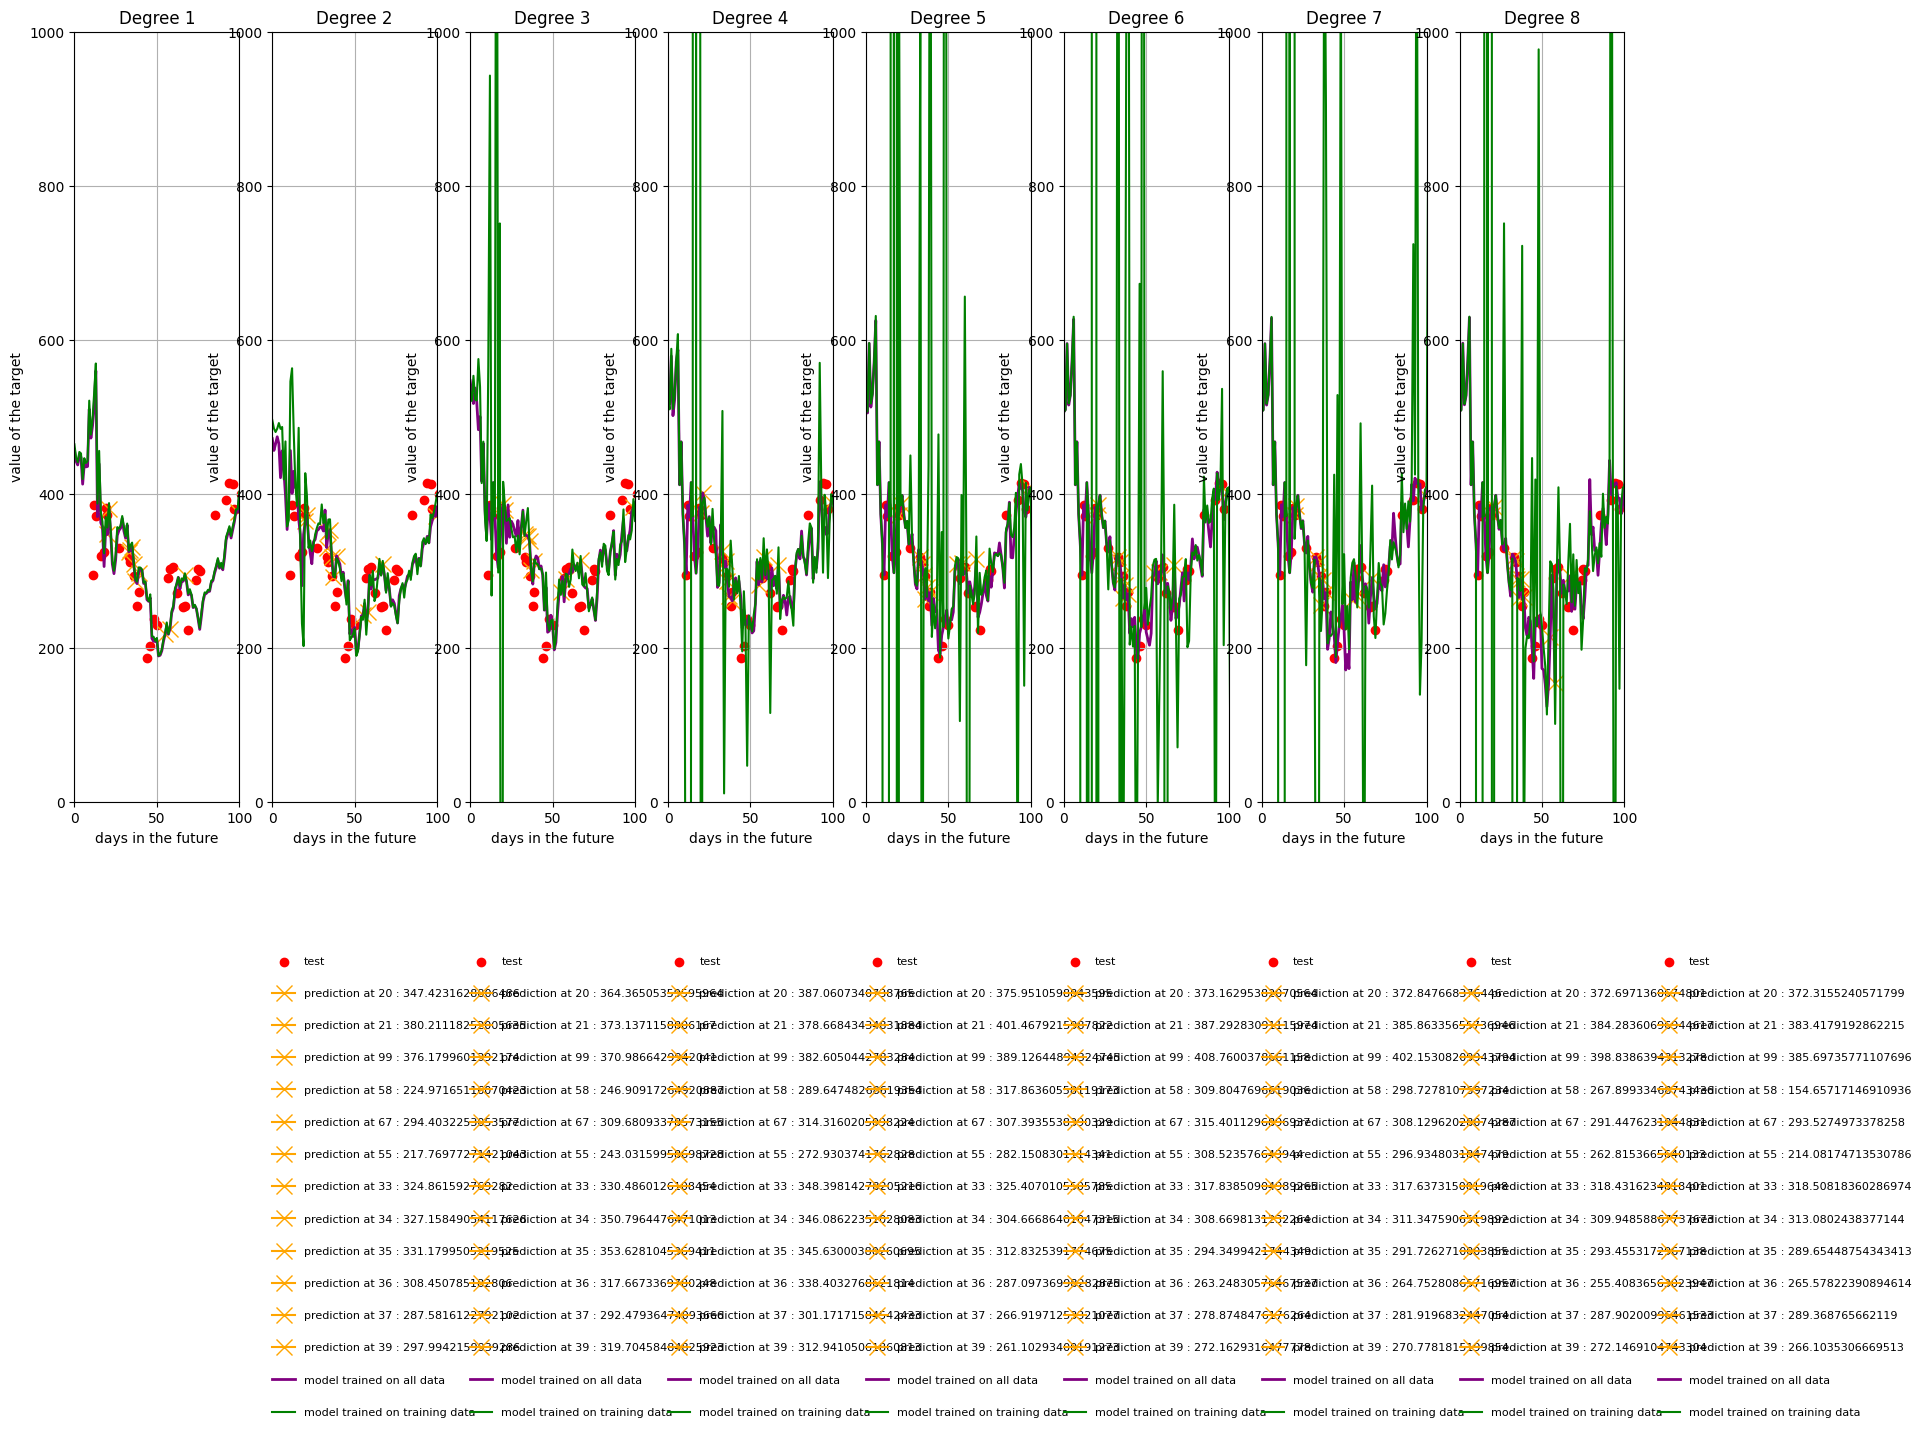

In [177]:
# # ## number of days since start | open | high | low | close | sma(10 days) | golden cross | death cross
# # ##          0                 |  1   |  2   |  3  |   4   |      5       |      6       |      7
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

polynomial_degrees = [1,2,3,4,5,6,7,8]
feature_indecies = [0,1,2,3,4,5,6,7]
pred_x_at_this_point = [20, 21, 99, 58, 67, 55, 33, 34, 35, 36, 37, 39]

def get_prediction_at_given_x(pipeln):
    for h in pred_x_at_this_point:
        x_row = X[h, feature_indecies].reshape(1, -1)
        y_pred_at_this_point = pipeln.predict(x_row)[0]
        # print(y_pred_at_this_point)
        # print(X[h,0])
        # print(h)
        ax.plot(h, y_pred_at_this_point, marker='x', color='orange', label=f'prediction at {h} : {y_pred_at_this_point}', markersize=12)
    
    

train_and_test_errors_at_given_degree = {}

plt.figure(figsize=(20,10))
for i in range(len(polynomial_degrees)):
    # print(X[:, feature_indecies].shape)
    # print(y.shape)
    
    ax = plt.subplot(1, len(polynomial_degrees), i + 1)
    ax = plt.subplot(1, len(polynomial_degrees), i + 1)
    
    ### NOTE: make the line eq a mutlti-var lin eq
    polynomial_features1 = PolynomialFeatures(degree=polynomial_degrees[i], include_bias=False)
    polynomial_features_train = PolynomialFeatures(degree=polynomial_degrees[i], include_bias=False)
    
    ### NOTE: apply lin reg to the new mutlti-var lin eq
    linear_regression_model1 = LinearRegression()
    linear_regression_model_train = LinearRegression()
    
    ### NOTE: instantiate the pipline
    pipeline1 = Pipeline([("polynomial_features", polynomial_features1), ("linear_regression", linear_regression_model1)])
    pipeline_on_training_data = Pipeline([("polynomial_features", polynomial_features_train), ("linear_regression", linear_regression_model_train)])
    
    ### NOTE: apply the pipline
    pipeline1.fit(X[:, feature_indecies], y)
    
    ##spilt 
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X[:, feature_indecies], y, test_size=0.3, random_state=67)

    ##fit 
    pipeline_on_training_data.fit(X_train2, y_train2)
    
    ##predict on train and test
    y_pred_train2 = pipeline_on_training_data.predict(X_train2)
    y_pred_test2 = pipeline_on_training_data.predict(X_test2)
    
    train_MAE2 = mean_absolute_error(y_train2, y_pred_train2)
    test_MAE2 = mean_absolute_error(y_test2, y_pred_test2)
    
    train_MSE2 = mean_squared_error(y_train2, y_pred_train2)
    test_MSE2 = mean_squared_error(y_test2, y_pred_test2)

    train_RMSE2 = np.sqrt(train_MSE2)
    test_RMSE2 = np.sqrt(test_MSE2)
    
    naive_MAE2 = mean_absolute_error(y_test2, np.full(y_test2.shape, np.mean(y_train2)))
    
    # for h in pred_x_at_this_point:
    #     y_pred_at_this_point = pipeline_on_training_data.predict(np.array([[h]+[0]*6]))[0]
    #     ax.plot(h, y_pred_at_this_point, marker='x', color='orange', label=f"pred at {h}")
        
    plt.xlabel('x')
    plt.ylabel('y')
    # ax.scatter(X0, y, color="blue")
    # ax.scatter(X_train2[:,0], y_train2, color="green", label='trian')
    ax.scatter(X_test2[:,0], y_test2, color="red", label='test')
    ax.set_xlim(0,100)
    ax.set_ylim(0,1000)
    
    LOBF_X = pipeline1.predict(X[:, feature_indecies])
    LOBF_train_set = pipeline_on_training_data.predict(X[:, feature_indecies])
    # LOBF_train_set = pipeline_on_training_data.predict(X_test2[:, feature_indecies])###### ask about this!!!!!!!
    
    get_prediction_at_given_x(pipeline1)
    
    ax.plot(X0, LOBF_X, label="model trained on all data", color="purple", linewidth=2)
    ax.plot(X0, LOBF_train_set, label="model trained on training data", color="green")
    
    ax.set_xlabel(f'days in the future')
    
    ax.set_ylabel('value of the target')
    ax.legend(loc='center left', bbox_to_anchor=(0.5, -0.5), ncol=1, fontsize=8, frameon=False, borderaxespad=10, labelspacing=2)
    plt.title(f"Degree {polynomial_degrees[i]}")
    ax.grid()   
    
    train_and_test_errors_at_given_degree[i] = {
        
        'train' : {
            'MAE' : train_MAE2,
            'MSE' : train_MSE2,
            'RMSE' : train_RMSE2
        },
        'test' : {
            'MAE' : test_MAE2,
            'MSE' : test_MSE2,
            'RMSE' : test_RMSE2
        }
    }
        

In [ ]:
for i in range(len(polynomial_degrees)):
    
    print(f"degree {i} train MAE : {train_and_test_errors_at_given_degree[i]['train']['MAE']}")
    print(f"degree {i} test MAE : {train_and_test_errors_at_given_degree[i]['test']['MAE']}")
    
    print(f"degree {i} train MSE : {train_and_test_errors_at_given_degree[i]['train']['MSE']}")
    print(f"degree {i} test MSE : {train_and_test_errors_at_given_degree[i]['test']['MSE']}")
    
    print(f"degree {i} train RMSE : {train_and_test_errors_at_given_degree[i]['train']['MSE']}")
    print(f"degree {i} test RMSE : {train_and_test_errors_at_given_degree[i]['test']['MSE']}")
    print()



degree 0 train MAE : 17.85736337503003
degree 0 test MAE : 17.624523800704836
degree 0 train MSE : 750.5573432704092
degree 0 test MSE : 814.3557123225249
degree 0 train RMSE : 750.5573432704092
degree 0 test RMSE : 814.3557123225249

degree 1 train MAE : 16.57848500636755
degree 1 test MAE : 18.780202535168304
degree 1 train MSE : 621.971409838405
degree 1 test MSE : 975.7925498432131
degree 1 train RMSE : 621.971409838405
degree 1 test RMSE : 975.7925498432131

degree 2 train MAE : 15.085931935016871
degree 2 test MAE : 26.18345742111851
degree 2 train MSE : 497.0582909009929
degree 2 test MSE : 13489.787492112191
degree 2 train RMSE : 497.0582909009929
degree 2 test RMSE : 13489.787492112191

degree 3 train MAE : 12.820697457342607
degree 3 test MAE : 205.4013492776002
degree 3 train MSE : 358.2484303237005
degree 3 test MSE : 5661315.880490886
degree 3 train RMSE : 358.2484303237005
degree 3 test RMSE : 5661315.880490886

degree 4 train MAE : 10.074525588104711
degree 4 test MAE : 

### show MAE, MSE, and RMSE and explain what this means for the predictions of the selected feature

#### * high train error, high test error --> underfitting
#### * low train error, high test error --> overfitting
#### * low train error, low test error --> well fitted